In [1]:
import os
import json
import pickle

In [2]:
gt_folder_path = f"../data/GroundTruth_cluster_eval"
# c1=[1,2,3,4]
# c2=[1,2,3,4]
# c3=[1,2,3,4]
# c4=[1,2,3,4]
# c5=[1,2,3,4]
gen_path = lambda root, files: [os.path.join(root, file) for file in files]

clusters_name = os.listdir(gt_folder_path)
clusters_path = gen_path(gt_folder_path, clusters_name)

print(clusters_name)

['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9']


# Model Load & Feature Extract

In [ ]:
from recognizer.deepface.deepface_algo_updated import ExtractorModel
json_file = "eval_deepface2.json"
model = ExtractorModel()

In [3]:
from recognizer.deepface.deepface_algo import ExtractorModel
json_file = "eval_deepface1.json"
model = ExtractorModel()

In [8]:
cluster_dict = {}
take_n = 10
for cls_id, cluster_path in enumerate(clusters_path):
    cluster_images = os.listdir(cluster_path)
    cluster_images_path = gen_path(cluster_path, cluster_images)[:take_n]
    # print(cluster_images_path)

    data = []
    for img_path in cluster_images_path:
        features = model.extract_img_feature(img_path)[0]
        values = {
            'cls_id': cls_id,
            'img_path': img_path,
            'features': list(features),
            }
        data.append(values)

    print(cluster_path, len(cluster_images_path), "features :", len(features))
    cluster_dict[cls_id] =  data
    # break

../data/GroundTruth_cluster_eval\cluster_0 10 features : 4096
../data/GroundTruth_cluster_eval\cluster_1 10 features : 4096
../data/GroundTruth_cluster_eval\cluster_2 10 features : 4096
../data/GroundTruth_cluster_eval\cluster_3 10 features : 4096
../data/GroundTruth_cluster_eval\cluster_4 10 features : 4096
../data/GroundTruth_cluster_eval\cluster_5 10 features : 4096
../data/GroundTruth_cluster_eval\cluster_6 10 features : 4096
../data/GroundTruth_cluster_eval\cluster_7 10 features : 4096
../data/GroundTruth_cluster_eval\cluster_8 10 features : 4096
../data/GroundTruth_cluster_eval\cluster_9 10 features : 4096


In [ ]:
# with open("eval_deepface2.pkl", 'w') as f:
#     pickle.dump(cluster_dict, f)

with open(json_file, 'w') as f:
    json.dump(cluster_dict, f, indent=2)

# Evaluation

In [ ]:
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [160]:
# json_file = "eval_deepface1.json"
json_file = "eval_deepface2.json"


with open(json_file) as f:
    cluster_dict = json.load(f)

In [161]:
cluster_keys = list(cluster_dict.keys())
n_clusters = len(cluster_keys)

score_matrix = np.zeros((n_clusters, n_clusters))
score_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [162]:
for i in range(n_clusters):
    print("    "*i, end='') 
    for j in range(i, n_clusters):
        print(f"{i},{j}", end=' ')
        cluster_i = cluster_dict[cluster_keys[i]]
        cluster_j = cluster_dict[cluster_keys[j]]
    
        scores = []
        for d1 in cluster_i:
            for d2 in cluster_j:
                # want to compare with self too
                score = cosine(d1['features'], d2['features'])
                scores.append(score)
        avg_score = np.mean(scores)
        # print(len(scores), avg_score)
        score_matrix[i][j] = avg_score
        score_matrix[j][i] = avg_score
    # break
    print()

0,0 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9 
    1,1 1,2 1,3 1,4 1,5 1,6 1,7 1,8 1,9 
        2,2 2,3 2,4 2,5 2,6 2,7 2,8 2,9 
            3,3 3,4 3,5 3,6 3,7 3,8 3,9 
                4,4 4,5 4,6 4,7 4,8 4,9 
                    5,5 5,6 5,7 5,8 5,9 
                        6,6 6,7 6,8 6,9 
                            7,7 7,8 7,9 
                                8,8 8,9 
                                    9,9 


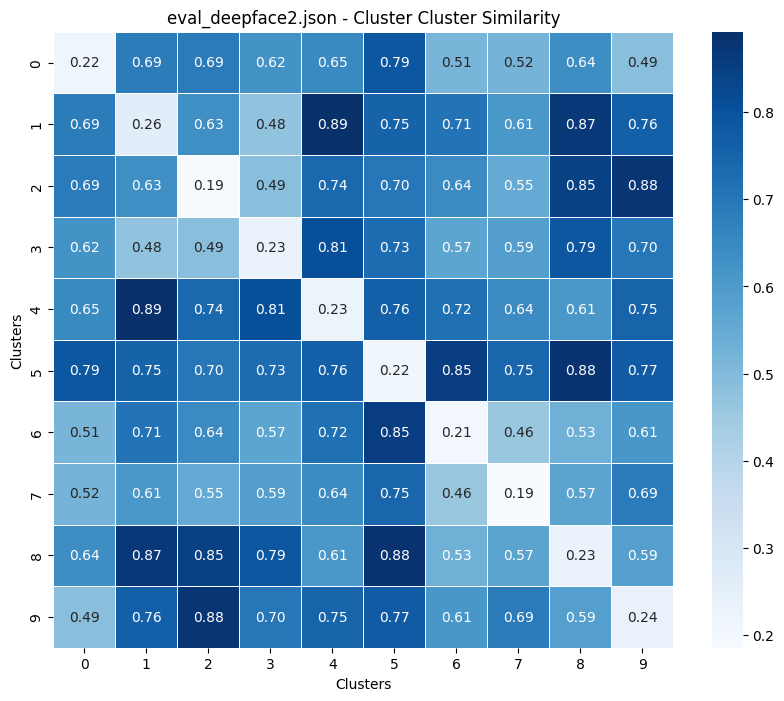

In [163]:
plt.figure(figsize=(10, 8))
sns.heatmap(score_matrix, annot=True, fmt='.2f', cmap='Blues', linewidths=0.5)
plt.xlabel('Clusters')
plt.ylabel('Clusters')
plt.title(f"{json_file} - Cluster Cluster Similarity")
plt.savefig(f"results_clscls_sim_{json_file}.png")
plt.show()

In [164]:
intra_scores = []
inter_scores = []

for cls_id in range(n_clusters):
    mask = np.zeros(10, bool) # all false
    mask[cls_id] = True
    intra_score = np.mean(score_matrix[cls_id][mask]) # self 
    inter_score = np.mean(score_matrix[cls_id][~mask]) # others
    # print(intra_score)
    # print(inter_score)
    intra_scores.append(intra_score)
    inter_scores.append(inter_score)

avg_intra = np.mean(intra_scores)
avg_inter = np.mean(inter_scores)

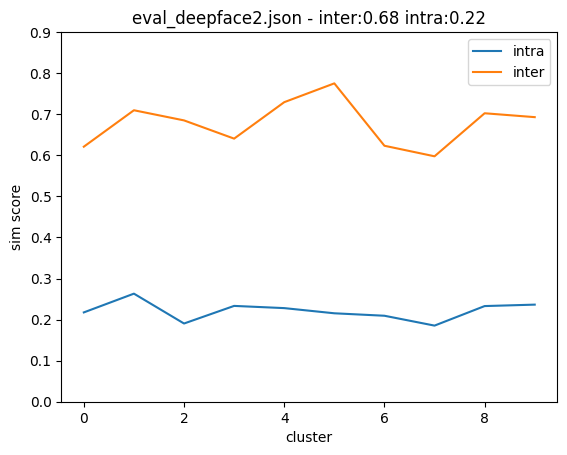

In [165]:
plt.title(f"{json_file} - inter:{avg_inter:.2f} intra:{avg_intra:.2f}")

plt.plot(intra_scores, label='intra')
plt.plot(inter_scores, label='inter')
plt.xlabel('cluster')
plt.ylabel('sim score')
plt.yticks(np.arange(0,1,0.1))
plt.legend()
plt.savefig(f"results_inter_intra_{json_file}.png")
plt.show()

In [166]:
# mask = np.ones(10, bool)
# mask
# ~mask
# mask[0]=False
# score_matrix[0][mask]

In [167]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [168]:
thresh = 0.25

gt = []
pred = []
scores = []
for cls_id in range(n_clusters):
    pred_cls = np.argmin(score_matrix[cls_id])

    score = score_matrix[cls_id][pred_cls]
    if score > thresh:
        pred_cls = -1
    gt.append(cls_id)
    pred.append(pred_cls)
    scores.append(score)

In [169]:
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute Accuracy (including -1, since it's just total correct / total samples)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Find valid predictions (excluding -1)
    valid_mask = y_pred != -1
    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]
    
    if len(y_pred_valid) == 0:
        precision = 0.0  # No valid predictions means precision is 0
    else:
        precision = precision_score(y_true_valid, y_pred_valid, average='weighted', zero_division=0)
    
    # Compute recall normally (it should penalize missed predictions)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return accuracy, precision, recall

In [170]:
gt, pred, scores

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, -1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0.21749175222716144,
  0.26317089091857615,
  0.19044121885808019,
  0.23332377672115207,
  0.227949009889703,
  0.21533787300439614,
  0.20936337543177466,
  0.18534591088480362,
  0.232920458610216,
  0.2364250802389723])

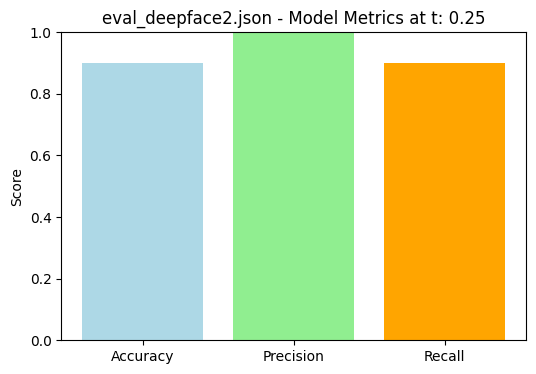

In [171]:
accuracy, precision, recall = compute_metrics(gt, pred)

metrics = ["Accuracy", "Precision", "Recall"]
values = [accuracy, precision, recall]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['lightblue', 'lightgreen', 'orange'])
plt.ylim(0, 1)
plt.ylabel("Score")

plt.title(f"{json_file} - Model Metrics at t: {thresh}")
plt.savefig(f"results_metrics_sim_{json_file}.png")
plt.show()